# Fortgeschrittenes Beispiel
In diesem Abschnitt wollen wir uns mit einem komplexeren Beispiel beschäftigen, um weitere Methoden von `iminuit` kennzulernen.
Hierzu betrachten wir ein Zählexperiment, z.B. ein Teilchendetektor, bei dem ein Energiespektrum aufgenommen wird. Für jedes Energieintervall (Bin) wird die Anzahl der registrierten Ereignisse bestimmt. Hierbei können wir annehmen, dass die Verteilung der gemessenen Anzahl durch eine Poisson-Verteilung beschrieben wird. Dann entspricht der Fehler in jedem Bin gerade $\sqrt n$. 
Dieses Spektrum soll aus zwei gauß-förmigen Peaks über einem exponentiellen Untergrund bestehen und wird mit Hilfe eines Zufallszahlengenerator "erzeugt".

Nun wollen wir die Messdaten mit Hilfe von `iminuit` fitten. Hierzu müssen wir zunächste zwei Module des packages importieren und eine Funktion für die Entladekurve des Kondensators definieren:

In [1]:
# Diese Zelle nur auf JupyterHub des ZDV ausführen um `iminuit` zu installieren!
# import sys
# import subprocess
# subprocess.check_call([
#     sys.executable, 
#     '-m',
#     'pip',
#     'install',
#     '--proxy',
#     'http://webproxy.zdv.uni-mainz.de:3128',
#     'iminuit'
# ])

In [2]:
from iminuit import Minuit, cost
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Number of counts per bin')

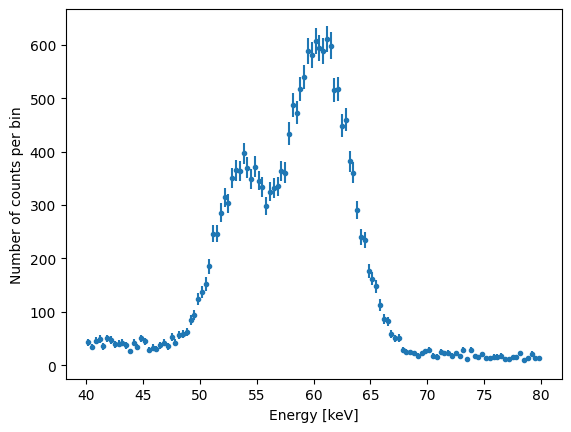

In [3]:
rnd_bkd = np.random.exponential(39.7, 5000)
rnd_bkd += 40

peak1 = np.random.normal(53.3, 2.1, 5000)
peak2 = np.random.normal(60.5, 2.78, 12000)
data = np.concatenate([rnd_bkd, peak1, peak2])

entries, edges = np.histogram(data, bins=120, range=(40, 80))
center = edges[:-1] + np.diff(edges)/2

plt.errorbar(center, entries, np.sqrt(entries), ls='', marker='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Number of counts per bin')

Zunächst wollen wir das Fitmodel in der Form

$$f(x) = A_1 \cdot \exp \bigg\{\frac{-(x - \mu_1)^2}{2 \cdot \sigma_1^2}\bigg\} + A_2 \cdot \exp \bigg\{\frac{-(x - \mu_2)^2}{2 \cdot \sigma_2^2}\bigg\} + A_3 \exp\{-x/\tau\}$$

definieren. Hier lohnt es sich, erst Funktionen für die einzelnen Komponenten zu definieren und dann das Gesamtmodel. Hierdurch lassen sich später die einzelnen Komponenten besser darstellen.

In [4]:
def peak(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def bkg(x, A, tau):
    return A*np.exp(-x/tau)

def fit_model(x, A_p1, A_p2, mu_p1, mu_p2, sigma_p1, sigma_p2, A_bkg, tau_bkg):
    return peak(x, A_p1, mu_p1, sigma_p1) + peak(x, A_p2, mu_p2, sigma_p2) + bkg(x, A_bkg, tau_bkg)

Nun wollen wir wieder die Kostenfunktion und die Minimierungsfunktion definieren. Startwerte können wir anhand unseres Plots ablesen, lediglich $\tau$ lässt sich auf diese Weise nicht gut bestimmen.

In [5]:
ls = cost.LeastSquares(center, entries, np.sqrt(entries), fit_model)

mi = Minuit(ls, 
            A_p1 = 400, 
            A_p2 = 700,
            mu_p1 = 54,
            mu_p2 = 60,
            sigma_p1 = 2,
            sigma_p2 = 2,
            A_bkg = 100,
            tau_bkg = 10, 
           )
mi.limits['tau_bkg'] = (0, None)

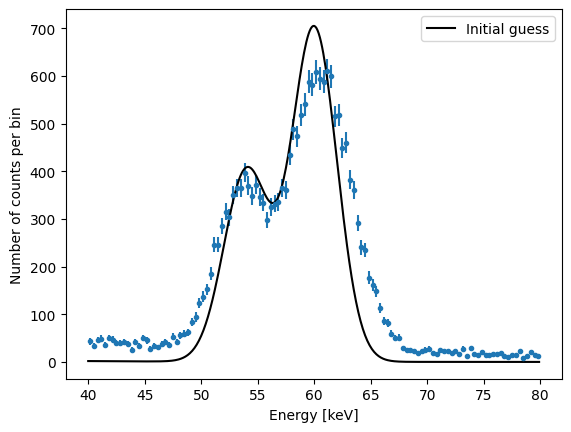

In [6]:
plt.errorbar(center, entries, np.sqrt(entries), ls='', marker='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Number of counts per bin')

x = np.arange(40, 80, 0.1)
plt.plot(x, fit_model(x, *mi.values), color='k', label='Initial guess')
plt.legend()

Unsere Startparameter sind bereits nicht schlecht, aber weichen noch stark von den Daten ab. Bei komplexeren Daten und Fitmodellen lohnt es sich, den Fit schrittweise durchzuführen. Bevor wir uns den beiden Peaks widmen, welche uns eigentlich interessieren, sollten wir versuchen, den Untergrund etwas besser zu beschreiben. Um den Untergrund besser fitten zu können, sollten wir erst den Fitbereich auf einen Energiebereich limitieren, in welchem der Untergrund dominiert. Dem Plot können wir entnehmen, dass dies für alle Werte unterhalb von 45 keV und oberhalb von 70 keV der Fall ist. Im Allgemeinen können wir Wertebereiche in Python mit Hilfe von „Masken“ selektieren. Eine Maske lässt sich wie folgt erstellen:

In [505]:
mask_outside_of_peaks = (center < 45) | (center >= 70)

Die Maske hat hierbei die Selbe länge wie unseren Daten…

In [506]:
len(mask_outside_of_peaks), len(mask_outside_of_peaks)

(120, 120)

… und beinhaltet Wahrheitswerte `True` und `False`, bzw. 1 und 0, mit welchen wir unsere Daten selektieren können:

In [507]:
mask_outside_of_peaks, center[mask_outside_of_peaks]

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([40.16666667, 40.5       , 40.83333333,

Unsere Selektion können wir an unsere Kostenfunktion direkt übergeben.

In [508]:
ls.mask = (center < 45) | (center >= 70)

Nun können wir nochmal unsere Funktion und Messwerte für den ausgewählten Bereich plotten…

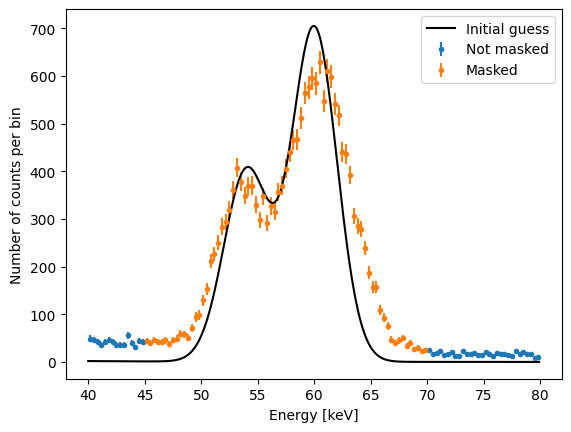

In [509]:
plt.errorbar(center[ls.mask], entries[ls.mask], np.sqrt(entries[ls.mask]), ls='', marker='.', label='Not masked')
plt.errorbar(center[~ls.mask], entries[~ls.mask], np.sqrt(entries[~ls.mask]), ls='', marker='.', label='Masked')
plt.xlabel('Energy [keV]')
plt.ylabel('Number of counts per bin')

x = np.arange(40, 80, 0.1)
plt.plot(x, fit_model(x, *mi.values), color='k', label='Initial guess')
plt.legend()

Außerdem müssen wir noch alle Fitparameter, welche nicht zum Untergrund beitragen, als konstant festhalten

In [510]:
mi.fixed[:] = True
mi.fixed[['tau_bkg', 'A_bkg']] = False
print (mi.fixed)

<FixedView A_p1=True A_p2=True mu_p1=True mu_p2=True sigma_p1=True sigma_p2=True A_bkg=False tau_bkg=False>


bevor wir die Minmierung starten und das Resultat darstellen.

In [511]:
mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.8 (χ²/ndof = 0.8)       │              Nfcn = 98               │
│ EDM = 4.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    400    │     4     │            │            │         │         │  yes  │
│ 1 │ A_p2     │    700    │     7     │            │            │         │         │  yes  │
│ 2 │ mu_p1    │   54.0    │    0.5    │            │            │         │         │  yes  │
│ 3 │ mu_p2    │   60.0    │    0.6    │            │            │         │         │  yes  │
│ 4 │ sigma_p1 │   2.00    │   0.02    │            │            │         │         │  yes  │
│ 5 │ sigma_p2 │   2.00    │   0.02    │            │            │         │         │  yes  │
│ 6 │ A_bkg    │    137    │    15     │            │            │         │         │       │
│ 7 │ tau_bkg  │   34.9    │    2.3    │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────┐
│          │     A_p1     A_p2    mu_p1    mu_p2 sigma_p1 sigma_p2    A_bkg  tau_bkg │
├──────────┼─────────────────────────────────────────────────────────────────────────┤
│     A_p1 │        0        0        0        0        0        0        0        0 │
│     A_p2 │        0        0        0        0        0        0        0        0 │
│    mu_p1 │        0        0        0        0        0        0        0        0 │
│    mu_p2 │        0        0        0        0        0        0        0        0 │
│ sigma_p1 │        0        0        0        0        0        0        0        0 │
│ sigma_p2 │        0        0        0        0        0        0        0        0 │
│    A_bkg │        0        0        0        0        0        0      229      -33 │
│  tau_bkg │        0        0        0        0        0        0      -33     5.18 │
└──────────┴─────────────────────────────────────────────────────────────────────────┘

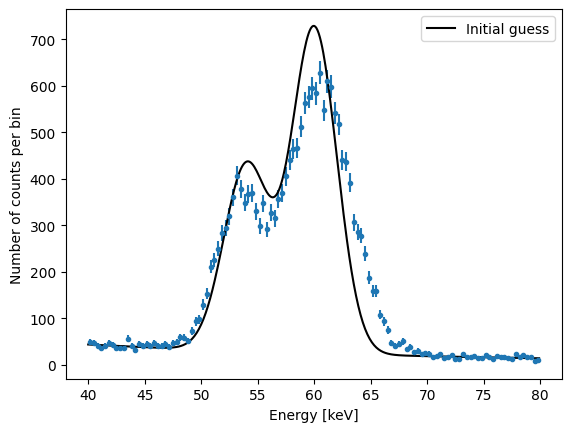

In [512]:
plt.errorbar(center, entries, np.sqrt(entries), ls='', marker='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Number of counts per bin')

x = np.arange(40, 80, 0.1)
plt.plot(x, fit_model(x, *mi.values), color='k', label='Initial guess')
plt.legend()


Das Resultat sieht bereits sehr gut aus. Nun können wir uns den eigentlichen Peaks widmen und starten im Folgenden mit dem kleineren der beiden. Zunächst sollten wir den maskierten Bereich entweder neu definieren oder komplett entfernen.

In [513]:
ls.mask = None

Außerdem können wir dem Plot entnehmen, dass durch den höheren Untergrund unsere Anfangsstartwerte nicht mehr ganz so gut passen. Diese können wir wie folgt aktualisieren:

In [514]:
mi.values['A_p1'] = 700
mi.values['sigma_p1'] = 3

Nun sollten wir alle Parameter wieder festhalten und nur die Parameter des ersten Peaks freigeben.

In [515]:
mi.fixed[:] = True
mi.fixed[['A_p1', 'mu_p1', 'sigma_p1']] = False
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1296 (χ²/ndof = 11.1)      │              Nfcn = 177              │
│ EDM = 2.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    348    │     7     │            │            │         │         │       │
│ 1 │ A_p2     │    700    │     7     │            │            │         │         │  yes  │
│ 2 │ mu_p1    │   53.51   │   0.04    │            │            │         │         │       │
│ 3 │ mu_p2    │   60.0    │    0.6    │            │            │         │         │  yes  │
│ 4 │ sigma_p1 │   2.085   │   0.034   │            │            │         │         │       │
│ 5 │ sigma_p2 │   2.00    │   0.02    │            │            │         │         │  yes  │
│ 6 │ A_bkg    │    137    │    15     │            │            │         │         │  yes  │
│ 7 │ tau_bkg  │   34.9    │    2.3    │            │            │    0    │         │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────┐
│          │     A_p1     A_p2    mu_p1    mu_p2 sigma_p1 sigma_p2    A_bkg  tau_bkg │
├──────────┼─────────────────────────────────────────────────────────────────────────┤
│     A_p1 │     42.2        0  -0.0042        0  -0.1247        0        0        0 │
│     A_p2 │        0        0   0.0000        0   0.0000        0        0        0 │
│    mu_p1 │  -0.0042   0.0000  0.00167   0.0000   0.0004   0.0000   0.0000   0.0000 │
│    mu_p2 │        0        0   0.0000        0   0.0000        0        0        0 │
│ sigma_p1 │  -0.1247   0.0000   0.0004   0.0000  0.00118   0.0000   0.0000   0.0000 │
│ sigma_p2 │        0        0   0.0000        0   0.0000        0        0        0 │
│    A_bkg │        0        0   0.0000        0   0.0000        0        0        0 │
│  tau_bkg │        0        0   0.0000        0   0.0000        0        0        0 │
└──────────┴─────────────────────────────────────────────────────────────────────────┘

Jetzt wiederholen wir das ganze für den zweiten Peak…

In [516]:
mi.fixed[:] = True
mi.fixed[['A_p2', 'mu_p2', 'sigma_p2']] = False
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 137 (χ²/ndof = 1.2)        │              Nfcn = 226              │
│ EDM = 1.24e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    348    │     7     │            │            │         │         │  yes  │
│ 1 │ A_p2     │    584    │     7     │            │            │         │         │       │
│ 2 │ mu_p1    │   53.51   │   0.04    │            │            │         │         │  yes  │
│ 3 │ mu_p2    │  60.605   │   0.031   │            │            │         │         │       │
│ 4 │ sigma_p1 │   2.085   │   0.034   │            │            │         │         │  yes  │
│ 5 │ sigma_p2 │   2.666   │   0.026   │            │            │         │         │       │
│ 6 │ A_bkg    │    137    │    15     │            │            │         │         │  yes  │
│ 7 │ tau_bkg  │   34.9    │    2.3    │            │            │    0    │         │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────┐
│          │      A_p1      A_p2     mu_p1     mu_p2  sigma_p1  sigma_p2     A_bkg   tau_bkg │
├──────────┼─────────────────────────────────────────────────────────────────────────────────┤
│     A_p1 │         0         0         0      0e-3         0         0         0         0 │
│     A_p2 │         0      55.2         0    0.7e-3         0 -110.5e-3         0         0 │
│    mu_p1 │         0         0         0      0e-3         0         0         0         0 │
│    mu_p2 │      0e-3    0.7e-3      0e-3  0.000983      0e-3   -0.2e-3      0e-3      0e-3 │
│ sigma_p1 │         0         0         0      0e-3         0         0         0         0 │
│ sigma_p2 │         0 -110.5e-3         0   -0.2e-3         0  0.000697         0         0 │
│    A_bkg │         0         0         0      0e-3         0         0         0         0 │
│  tau_bkg │         0         0         0      0e-3         0         0         0         0 │
└──────────┴─────────────────────────────────────────────────────────────────────────────────┘

Zum Schluss geben wir wieder alle Parameter frei und führen einen letzten Fit durch. 

In [517]:
mi.fixed[:] = False
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 106.4 (χ²/ndof = 0.9)      │              Nfcn = 500              │
│ EDM = 4.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    317    │     7     │            │            │         │         │       │
│ 1 │ A_p2     │    580    │     7     │            │            │         │         │       │
│ 2 │ mu_p1    │   53.24   │   0.07    │            │            │         │         │       │
│ 3 │ mu_p2    │   60.43   │   0.05    │            │            │         │         │       │
│ 4 │ sigma_p1 │   1.99    │   0.05    │            │            │         │         │       │
│ 5 │ sigma_p2 │   2.80    │   0.04    │            │            │         │         │       │
│ 6 │ A_bkg    │    147    │    14     │            │            │         │         │       │
│ 7 │ tau_bkg  │   34.1    │    2.0    │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────┐
│          │     A_p1     A_p2    mu_p1    mu_p2 sigma_p1 sigma_p2    A_bkg  tau_bkg │
├──────────┼─────────────────────────────────────────────────────────────────────────┤
│     A_p1 │     51.5       10    0.103   0.1006  -0.0808  -0.0969       -0        0 │
│     A_p2 │       10     50.6    0.026   0.0402  -0.0047  -0.1329       -0        0 │
│    mu_p1 │    0.103    0.026  0.00503   0.0027   0.0025  -0.0020   -0.057    0.010 │
│    mu_p2 │   0.1006   0.0402   0.0027  0.00276   0.0018  -0.0015  -0.0515   0.0062 │
│ sigma_p1 │  -0.0808  -0.0047   0.0025   0.0018  0.00297  -0.0012  -0.1413   0.0156 │
│ sigma_p2 │  -0.0969  -0.1329  -0.0020  -0.0015  -0.0012  0.00171   0.0818  -0.0143 │
│    A_bkg │       -0       -0   -0.057  -0.0515  -0.1413   0.0818      209      -28 │
│  tau_bkg │        0        0    0.010   0.0062   0.0156  -0.0143      -28     4.03 │
└──────────┴─────────────────────────────────────────────────────────────────────────┘

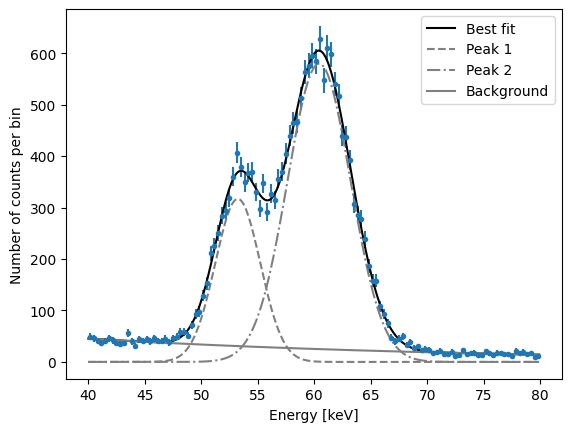

In [518]:
plt.errorbar(center, entries, np.sqrt(entries), ls='', marker='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Number of counts per bin')

x = np.arange(40, 80, 0.1)
plt.plot(x, fit_model(x, *mi.values), color='k', label='Best fit')
plt.plot(x, peak(x, *mi.values['A_p1', 'mu_p1', 'sigma_p1']), color='gray', ls='--', label='Peak 1')
plt.plot(x, peak(x, *mi.values['A_p2', 'mu_p2', 'sigma_p2']), color='gray', ls='-.', label='Peak 2')
plt.plot(x, bkg(x, *mi.values['A_bkg', 'tau_bkg']), color='gray', label='Background')
plt.legend()


Das Ergebnis sieht sehr gut aus. Alle Kacheln sind grün und die Daten scheinen durch die Funktion gut beschrieben zu werden. Natürlich können wir das gesamte Fitverfahren auch etwas kompakter in einer Zelle darstellen:

In [519]:
ls = cost.LeastSquares(center, entries, np.sqrt(entries), fit_model)

mi = Minuit(ls, 
            A_p1 = 800, 
            A_p2 = 1400,
            mu_p1 = 54,
            mu_p2 = 60,
            sigma_p1 = 2,
            sigma_p2 = 2,
            A_bkg = 100,
            tau_bkg = 10, 
           )
mi.limits['tau_bkg'] = (0, None)
mi.fixed[:] = True
ls.mask = (center < 45) | (center >= 70)
mi.fixed[['tau_bkg', 'A_bkg']] = False
mi.migrad()
ls.mask = None
mi.values['A_p1'] = 700
mi.values['sigma_p1'] = 3
mi.fixed[:] = True
mi.fixed[['A_p1', 'mu_p1', 'sigma_p1']] = False
mi.migrad()
mi.fixed[:] = True
mi.fixed[['A_p2', 'mu_p2', 'sigma_p2']] = False
mi.migrad()
mi.fixed[:] = False
mi.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 106.4 (χ²/ndof = 0.9)      │              Nfcn = 530              │
│ EDM = 1.61e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    317    │     7     │            │            │         │         │       │
│ 1 │ A_p2     │    580    │     7     │            │            │         │         │       │
│ 2 │ mu_p1    │   53.24   │   0.07    │            │            │         │         │       │
│ 3 │ mu_p2    │   60.43   │   0.05    │            │            │         │         │       │
│ 4 │ sigma_p1 │   1.99    │   0.05    │            │            │         │         │       │
│ 5 │ sigma_p2 │   2.80    │   0.04    │            │            │         │         │       │
│ 6 │ A_bkg    │    147    │    14     │            │            │         │         │       │
│ 7 │ tau_bkg  │   34.1    │    2.0    │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────┐
│          │     A_p1     A_p2    mu_p1    mu_p2 sigma_p1 sigma_p2    A_bkg  tau_bkg │
├──────────┼─────────────────────────────────────────────────────────────────────────┤
│     A_p1 │     51.5       10    0.103   0.1006  -0.0808  -0.0969       -0        0 │
│     A_p2 │       10     50.6    0.026   0.0402  -0.0047  -0.1329       -0        0 │
│    mu_p1 │    0.103    0.026  0.00503   0.0027   0.0025  -0.0020   -0.057    0.010 │
│    mu_p2 │   0.1006   0.0402   0.0027  0.00276   0.0018  -0.0015  -0.0513   0.0062 │
│ sigma_p1 │  -0.0808  -0.0047   0.0025   0.0018  0.00297  -0.0012  -0.1409   0.0155 │
│ sigma_p2 │  -0.0969  -0.1329  -0.0020  -0.0015  -0.0012  0.00171   0.0816  -0.0142 │
│    A_bkg │       -0       -0   -0.057  -0.0513  -0.1409   0.0816      209      -28 │
│  tau_bkg │        0        0    0.010   0.0062   0.0155  -0.0142      -28     4.01 │
└──────────┴─────────────────────────────────────────────────────────────────────────┘

 # Wann fittet ein Fit?
Nach dem wir nun unser Model an unsere Daten angepasst haben, stellt sich die Frage: „Spiegelt unser Model unsere Daten gut wider?“.  Um diese Frage beantworten zu können, gibt es verschiedene Möglichkeiten, welche wir im Folgenden etwas näher betrachten wollen. 
## Fit Residual: 
Schauen wir uns zunächst noch einmal an, wie das Chi-Quadrat definiert ist:
$$ \chi^2 = \sum_i \frac{(y_i - \lambda_i)^2}{\Delta y_i^2} $$
Wir minimieren den Abstand zwischen einem Messwert und unserem Model und gewichten diesen mit den Unsicherheiten unserer Messwerte. Fitresiduen spiegeln genau dies wider. Sie sind definiert als 
$$ \frac{(y_i - \lambda_i)}{\Delta y_i} $$
Für unseren Fit sehen sie wie folgt aus.


Text(0, 0.5, 'Residuals [$\\sigma$]')

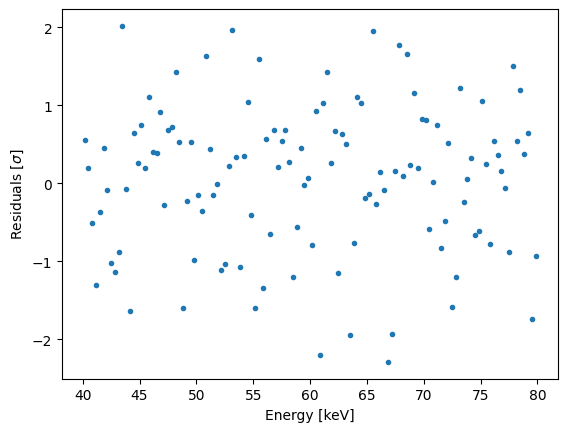

In [520]:
residuals = (entries - fit_model(center, *mi.values))/np.sqrt(entries)

plt.plot(center, residuals, ls='', marker='.')
plt.xlabel('Energy [keV]')
plt.ylabel('Residuals [$\sigma$]')

Als einzelner Plot sind sie noch nicht sehr informativ. Hilfreicher ist es bereits, wenn wir die Residuen zusammen mit unseren Daten und Fitmodel darstellen. 

C:\Users\Matthias\AppData\Local\Temp\ipykernel_67644\53208542.py:7: UserWarning: The figure layout has changed to tight
  fig_fit.tight_layout()


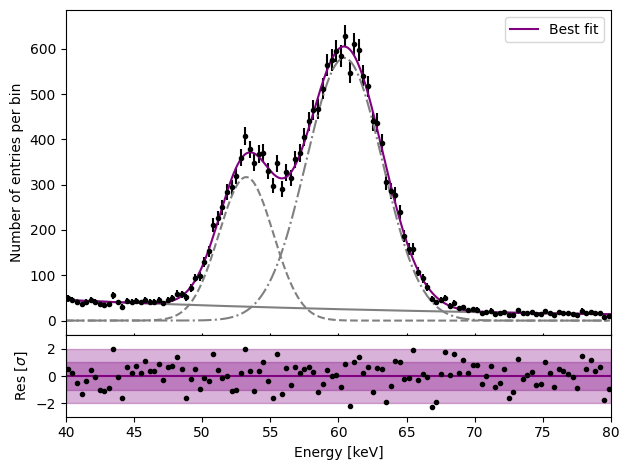

In [521]:
fig_fit = plt.figure(constrained_layout=True)
gs = fig_fit.add_gridspec(5, 5, hspace=0)


main_axis = fig_fit.add_subplot(gs[:4, :])
res_axis = fig_fit.add_subplot(gs[4:, :], sharex=main_axis)
fig_fit.tight_layout()


main_axis.errorbar(center, entries, np.sqrt(entries), ls='', marker='.', color='k')

main_axis.plot(x, peak(x, *mi.values['A_p1', 'mu_p1', 'sigma_p1']), color='gray', ls='--')
main_axis.plot(x, peak(x, *mi.values['A_p2', 'mu_p2', 'sigma_p2']), color='gray', ls='-.')
main_axis.plot(x, bkg(x, *mi.values['A_bkg', 'tau_bkg']), color='gray')

x = np.arange(40, 80, 0.1)
main_axis.plot(x, fit_model(x, *mi.values), color='purple', label='Best fit')
main_axis.legend()
main_axis.set_ylabel('Number of entries per bin')
main_axis.xaxis.set_tick_params(direction='inout')
main_axis.tick_params(axis='x', labelcolor=(0, 0, 0, 0))
main_axis.set_xlim(40, 80)

res_axis.set_xlabel('Energy [keV]')
res_axis.set_ylabel('Res [$\sigma$]')
res_axis.set_ylim(-3, 3)
res_axis.set_yticks([-2, 0,  2])
res_axis.fill_between((40, 80), -1, 1, alpha=0.3, color='purple')
res_axis.fill_between((40, 80), -2, 2, alpha=0.3, color='purple')
res_axis.axhline(0, color='purple')
res_axis.set_xlim(40, 80)
res_axis.plot(center, 
              residuals,
              color='k', marker='.', ls=''
             )
plt.tight_layout()

Sofern unser Fitmodel unsere Daten gut beschreibt, erwarten wir, dass die Residuen sich Gaußförmig zufällig um den Wert 0 herum verteilen. Dies folgt direkt aus der Annahme, dass sich die Unsicherheiten unserer Messwerte durch eine Gaußverteilung darstellen lassen. Dies können wir direkt überprüfen, sofern wir unsere Residuen in ein Histogramm eintragen. 

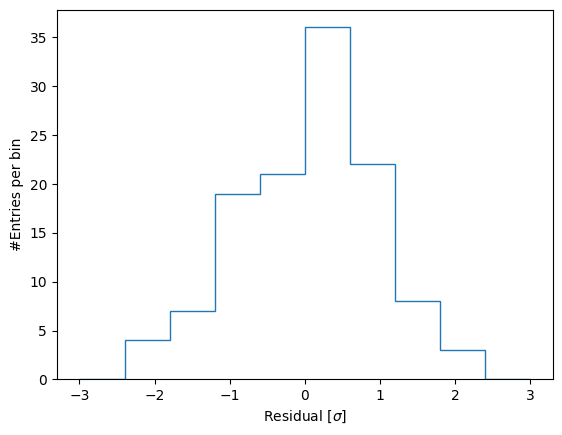

In [522]:
plt.hist(residuals, bins=10, range=(-3, 3), histtype='step')
plt.xlabel('Residual [$\sigma$]')
plt.ylabel('#Entries per bin')
plt.show()

Bzw. den Anteil an Residuen berechnen, welcher innerhalb der 1 $\sigma$ Umgebung liegt.

In [523]:
np.sum(np.abs(residuals) < 1)/len(residuals)

0.6833333333333333

Zeigen unsere Residuen eine Struktur oder ein systematisches Verhalten, deutet dies auf einen ungenauen Fit oder ein falsches Fitmodel hin. Dies ist im Folgenden gezeigt. 

C:\Users\Matthias\AppData\Local\Temp\ipykernel_67644\2321973434.py:8: UserWarning: The figure layout has changed to tight
  fig_fit.tight_layout()


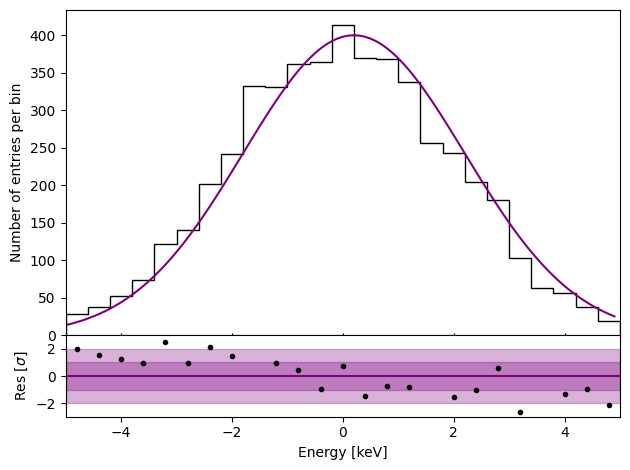

In [524]:
pseudo_data = np.random.normal(0, 2, 5000)

fig_fit = plt.figure(constrained_layout=True)
gs = fig_fit.add_gridspec(5, 5, hspace=0)

main_axis = fig_fit.add_subplot(gs[:4, :])
res_axis = fig_fit.add_subplot(gs[4:, :], sharex=main_axis)
fig_fit.tight_layout()

entries1, edges1, _ = main_axis.hist(pseudo_data, bins=25, range=(-5,5), histtype='step', color='k')
center1 = edges1[:-1] + np.diff(edges1)/2

residuals1 = (entries1 - peak(center1, 400, 0.2, 2))/np.sqrt(entries1)

x = np.arange(-5, 5, 0.1)

main_axis.plot(x, peak(x, 400, 0.2, 2), color='purple')
main_axis.set_ylabel('Number of entries per bin')
main_axis.xaxis.set_tick_params(direction='inout')
main_axis.tick_params(axis='x', labelcolor=(0, 0, 0, 0))
main_axis.set_xlim(-5, 5)

res_axis.set_xlabel('Energy [keV]')
res_axis.set_ylabel('Res [$\sigma$]')
res_axis.set_ylim(-3, 3)
res_axis.set_yticks([-2, 0,  2])
res_axis.fill_between((-5, 5), -1, 1, alpha=0.3, color='purple')
res_axis.fill_between((-5, 5), -2, 2, alpha=0.3, color='purple')
res_axis.axhline(0, color='purple')
res_axis.set_xlim(-5, 5)
res_axis.plot(center1, 
              residuals1,
              color='k', marker='.', ls=''
             )
plt.tight_layout()

Zusätzlich zu den Fit-Residuen bietet das $\chi^2$ selbst einen Weg, um die „goodness-of-fit“ unseres Model bestimmen zu können ...

### $\chi^2$:

Wie gut fittet unsere obige Funktion unsere Messdaten? Sehr gut? Gut? Befriedigend? Oder doch eher schlecht?   Wäre es nicht gut, ein Maß für die Güte des Fits zu haben? Wie könnte ein solches Maß aussehen?

Sie haben das entscheidende Kriterium bereits kennengelernt: bei der Methode der kleinsten Quadrate geht es darum, das  $\chi^2$ zu minimieren. Gucken wir uns hierzu erst noch einmal an, wie sich das $\chi^2$ berechnet:

$$ \chi(\phi_1 ... \phi_N)^2 = \sum_{i = 1}^{N} \frac{ (y_i - \lambda(x_i; \phi))^2}{\Delta y_i^2}$$

Bei der Minimierung werden dabei Werte mit geringerer Unsicherheit bevorzugt, d.h. stärker gewichtet (s. Bild unten).

<figure class="image">
<img src="images/MaterialPythonkurs092018/LeastSquare.png"  alt="{{ Least Square Beispiel }}" width=80%>
</figure>

Damit man für einen gegebenen Datensatz nicht hunderte von verschiedenen Funktionen durchprobieren muss, gibt es für das $\chi^2$ eine allgemeine Faustregel, welche den berechneten $\chi^2$-Wert mit der Anzahl unserer Freiheitsgrade vergleicht. Die Anzahl an Freiheitsgrade ist gemeinhin gegeben als *Anzahl der Messwerte - Anzahl der Funktionsparameter* ($m - n$).

1. Sofern  $\chi^2/\text{ndof} >> 1$: sollte die Hypothese bzw. die Fitfunktion angezweifelt werden. Sie beschreibt in diesem Fall die Messdaten nur unzureichend. (Bzw. sollte $\chi^2/\text{ndof} > 1$ kann dies auch bedeuten, dass die Unsicherheiten unterschätzt sind)
2. Sofern $\chi^2/\text{ndof} \approx 1$: beschreibt die Hypothese bzw. die Fitfunktion die Daten wie erwartet und wird nicht abgelehnt. 
3. Falls $\chi^2/\text{ndof} << 1$ beschreibt die Hypothese bzw. die Fitfunktion die Daten wesentlich besser als erwartet. In diesem Fall heißt das nicht automatisch, dass unsere Hypothese falsch ist, aber man sollte überprüfen, ob die gemessenen Fehler nicht überschätzt worden sind (oder eine Korrelation zwischen den Messfehlern vorliegt).  

Sofern Sie eine Arbeit schreiben und Ihre **Goodness-of-the-Fit** ($\chi^2/\text{ndof}$) angeben wollen, so geben Sie immer beides an, das $\chi^2$ und die Anzahl an Freiheitsgraden *ndof*. Beide Werte getrennt haben einen größeren Informationsgehalt als der resultierende Quotient (Genaueres lernen Sie z.B. in der Vorlesung *Statistik, Datenanalyse und Simulationen* im Master).

Sehen wir uns hierzu nochmal unseren Doppelpeakfit etwas genauer an. `iminuit` berechnet hier für uns bereits das reduzierete $\chi^2$.

In [525]:
mi

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 106.4 (χ²/ndof = 0.9)      │              Nfcn = 530              │
│ EDM = 1.61e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    317    │     7     │            │            │         │         │       │
│ 1 │ A_p2     │    580    │     7     │            │            │         │         │       │
│ 2 │ mu_p1    │   53.24   │   0.07    │            │            │         │         │       │
│ 3 │ mu_p2    │   60.43   │   0.05    │            │            │         │         │       │
│ 4 │ sigma_p1 │   1.99    │   0.05    │            │            │         │         │       │
│ 5 │ sigma_p2 │   2.80    │   0.04    │            │            │         │         │       │
│ 6 │ A_bkg    │    147    │    14     │            │            │         │         │       │
│ 7 │ tau_bkg  │   34.1    │    2.0    │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────┐
│          │     A_p1     A_p2    mu_p1    mu_p2 sigma_p1 sigma_p2    A_bkg  tau_bkg │
├──────────┼─────────────────────────────────────────────────────────────────────────┤
│     A_p1 │     51.5       10    0.103   0.1006  -0.0808  -0.0969       -0        0 │
│     A_p2 │       10     50.6    0.026   0.0402  -0.0047  -0.1329       -0        0 │
│    mu_p1 │    0.103    0.026  0.00503   0.0027   0.0025  -0.0020   -0.057    0.010 │
│    mu_p2 │   0.1006   0.0402   0.0027  0.00276   0.0018  -0.0015  -0.0513   0.0062 │
│ sigma_p1 │  -0.0808  -0.0047   0.0025   0.0018  0.00297  -0.0012  -0.1409   0.0155 │
│ sigma_p2 │  -0.0969  -0.1329  -0.0020  -0.0015  -0.0012  0.00171   0.0816  -0.0142 │
│    A_bkg │       -0       -0   -0.057  -0.0513  -0.1409   0.0816      209      -28 │
│  tau_bkg │        0        0    0.010   0.0062   0.0155  -0.0142      -28     4.01 │
└──────────┴─────────────────────────────────────────────────────────────────────────┘

Eine eigene Abschätzung für das $\chi^2$ ergibt:

In [526]:
def chi_square_ndof(x_values, y_values, dy_values, fit_model, minuit):
    ndof = len(x_values) - len(minuit.values)
    chi2 = np.sum((y_values - fit_model(x_values, *minuit.values))**2/dy_values**2)
    return chi2, ndof


chi_square, ndof = chi_square_ndof(center, entries, np.sqrt(entries), fit_model, mi)
print(chi_square, ndof, chi_square/ndof)

106.36771764289108 112 0.9497117646686704


### Hypothesen-Test mittels $\chi^2$
Wie schon im vorherigen Abschnitt erwähnt, kann man das $\chi^2$ auch dazu verwenden, die Gültigkeit des gewählten Models zu prüfen.
Hierzu schauen wir uns die $\chi^2$-Verteilung an. Der einzige freie Parameter ist die Anzahl der Freiheitsgrade. Die Anzahl der Freiheitsgrade ist auch gleichzeitig der Erwartungswert der $\chi^2$-Verteilung. In unserem Beispiel oben ist die Anzahl der Freiheitsgrade 112 und die entsprechende Verteilung sieht wie folgt aus...

In [527]:
from scipy.stats import chi2
# chi_distribution = lambda x, ndof: chi2.pdf(x, ndof)

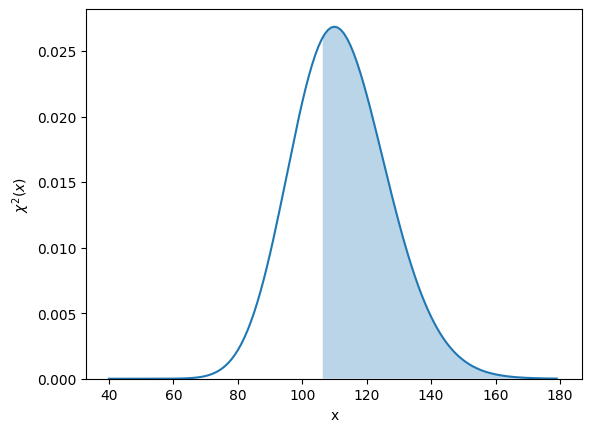

In [528]:
x = np.arange(40., 180.)
# plt.plot(x, chi_distribution(x, 112))
plt.plot(x,chi2.pdf(x, 112))
x = np.arange(chi_square, 180, 0.1)
plt.fill_between(x, chi2.pdf(x, 112), alpha=0.3)
plt.ylim(0, None)
plt.xlabel('x')
plt.ylabel('$\chi^2(x)$')
plt.show()

Der erste Schritt für den Hypothesen-Test ist die Berechnung des $P$-Werts
$$ P = \int_{\chi^2}^{\infty} f(z,n_d)dz $$
wobei $f(z,n_d)$ die $\chi^2$-Verteilung und $n_d$ die Anzahl der Freiheitsgrade ist.
Im Bild oben entspricht dies der ausgefüllten Fläche.

Die praktische Berechnung erfolgt mittels der kumulativen Verteilungsfunktion via
$$ P = 1 - \chi^2_{CDF}(x, n_d) $$
wobei für $x$ das im Fit bestimmte $\chi^2$ eingesetzt wird. Die praktische Bedeutung des $P$-Werts ist die Wahrscheinlichkeit bei einer Wiederholung des Experiments in größeres $\chi^2$ zu erhalten, wenn unser Model die Daten richtig beschreibt und die ermittelten Fitparameter den wahren Werten entsprechen.

In [529]:
p_value = lambda x, ndof: 1 - chi2.cdf(x, ndof)
p_value(chi_square, ndof), p_value(chi_square*10, ndof*10), p_value(ndof, ndof)

(0.6323451110506132, 0.884238547608047, 0.48222800598351057)

Kehren wir zu unserem Doppelpeak-Spektrum zurück und änderen das Fitmodell, indem wir statt eines exponentiellen einen konstanten Untergrund annehmen.

In [530]:
def alternative_fit_model(x, A_p1, A_p2, mu_p1, mu_p2, sigma_p1, sigma_p2, c):
    return peak(x, A_p1, mu_p1, sigma_p1) + peak(x, A_p2, mu_p2, sigma_p2) + c

ls = cost.LeastSquares(center, entries, np.sqrt(entries), alternative_fit_model)

mi = Minuit(ls, 
            A_p1 = 800, 
            A_p2 = 1400,
            mu_p1 = 54,
            mu_p2 = 60,
            sigma_p1 = 2,
            sigma_p2 = 2,
            c = 100, 
           )
mi.limits['c'] = (0, None)
mi.fixed[:] = True
ls.mask = (center < 45) | (center >= 70)
mi.fixed[['c']] = False
mi.migrad()
ls.mask = None
mi.values['A_p1'] = 700
mi.values['sigma_p1'] = 3
mi.fixed[:] = True
mi.fixed[['A_p1', 'mu_p1', 'sigma_p1']] = False
mi.migrad()
mi.fixed[:] = True
mi.fixed[['A_p2', 'mu_p2', 'sigma_p2']] = False
mi.migrad()
mi.fixed[:] = False
mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 369.6 (χ²/ndof = 3.3)      │              Nfcn = 415              │
│ EDM = 5.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A_p1     │    319    │     7     │            │            │         │         │       │
│ 1 │ A_p2     │    583    │     7     │            │            │         │         │       │
│ 2 │ mu_p1    │   53.31   │   0.08    │            │            │         │         │       │
│ 3 │ mu_p2    │   60.52   │   0.06    │            │            │         │         │       │
│ 4 │ sigma_p1 │   2.23    │   0.07    │            │            │         │         │       │
│ 5 │ sigma_p2 │   2.72    │   0.04    │            │            │         │         │       │
│ 6 │ c        │   21.4    │    0.6    │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬────────────────────────────────────────────────────────────────┐
│          │     A_p1     A_p2    mu_p1    mu_p2 sigma_p1 sigma_p2        c │
├──────────┼────────────────────────────────────────────────────────────────┤
│     A_p1 │     47.8       10    0.096   0.0895   -0.108  -0.0881      0.1 │
│     A_p2 │       10     52.4   -0.036  -0.0034   -0.064  -0.1062      0.0 │
│    mu_p1 │    0.096   -0.036  0.00694   0.0038    0.004  -0.0025    0.002 │
│    mu_p2 │   0.0895  -0.0034   0.0038  0.00333   0.0027  -0.0017  -0.0018 │
│ sigma_p1 │   -0.108   -0.064    0.004   0.0027  0.00444  -0.0016   -0.005 │
│ sigma_p2 │  -0.0881  -0.1062  -0.0025  -0.0017  -0.0016  0.00179  -0.0033 │
│        c │      0.1      0.0    0.002  -0.0018   -0.005  -0.0033     0.39 │
└──────────┴────────────────────────────────────────────────────────────────┘

Diese Änderung ist gering und der Fit scheint die Daten weiterhin zu beschreiben. Allerdings gibt bei kleinen Energien eine deutlich sichtbare Diskrepanz. Dies zeigt sich auch in einem größeren $\chi^2$-Wert. Wie wirkt sich dies auf den $P$-Wert aus?

In [478]:
chi_square, ndof = chi_square_ndof(center, entries, np.sqrt(entries), alternative_fit_model, mi)
print(chi_square, ndof, chi_square/ndof)

329.01941626278426 113 2.911676250113135


In [479]:
p_value = lambda x, ndof: 1 - chi2.cdf(x, ndof)
print(chi_square, ndof)
p_value(chi_square, ndof)

329.01941626278426 113


0.0

Der Fit ist offensichtlich viel schlechter und der $P$-Wert liegt nahe bei null, so dass man dieses Model ausschließen sollte.

Was aber, wenn die Änderung nicht so dramatisch ist? Ist ein $P$-Wert von 0,4 besser als 0,2? Nein, das kann man so nicht beantworten. Aber für einen Hypothesen-Test sollten man vorher eine Schwelle festlegen für die Akzeptanz oder Ablehnung des Models.

Wie ein solcher Hypothesen-Test aussehen kann, wollen wir im Folgenden betrachten. Hierbei benutzen wir
1. ein korrektes Model (Normalverteilung),
2. ein korrektes Model mit überschätztem Fehler (10% größer),
3. und ein falsches Model (Lorentzverteilung)

In [264]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

Den Fit der drei Modelle und die Bestimmung des entsprechenden $P$-Werts wiederholen wir 5000-mal um eine ausreichende Statistik zu erhalten.

In [7]:
# Diese Zelle nur auf JupyterHub des ZDV ausführen um `tqdm` zu installieren falls es nicht vorhanden sein sollte!
# import sys
# import subprocess
# subprocess.check_call([
#     sys.executable, 
#     '-m',
#     'pip',
#     'install',
#     '--proxy',
#     'http://webproxy.zdv.uni-mainz.de:3128',
#     'tqdm'
# ])

In [531]:
from tqdm.notebook import tqdm

res_good_model = []
res_overfitting = []
res_wrong_model = []

def peak(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)


for i in tqdm(range(5000)):
    
    test_data = np.random.normal(0, 2, 5000)
    
    entries, edges = np.histogram(test_data, bins=25, range=(-4,4))
    center = edges[:-1] + np.diff(edges)/2
    
    ls = cost.LeastSquares(center, entries, np.sqrt(entries), peak)
    mi = Minuit(ls, 
                mu=0.1,
                sigma=1.5,
                A = 300
               )
    mi.migrad()
    
    chi, ndof = chi_square_ndof(center, entries, np.sqrt(entries), peak, mi)
    res_good_model.append(p_value(chi, ndof))


    ls = cost.LeastSquares(center, entries, np.sqrt(entries)*1.1, peak)
    mi = Minuit(ls, 
                mu=0.1,
                sigma=1.5,
                A = 300
               )
    mi.migrad()
    
    chi, ndof = chi_square_ndof(center, entries, np.sqrt(entries)*1.1, peak, mi)
    res_overfitting.append(p_value(chi, ndof))


    ls = cost.LeastSquares(center, entries, np.sqrt(entries), lorentzian)
    mi = Minuit(ls, 
                x0=0,
                gam=3,
                a = 300,
               )
    mi.migrad()
    
    chi, ndof = chi_square_ndof(center, entries, np.sqrt(entries), lorentzian, mi)
    res_wrong_model.append(p_value(chi, ndof))

res_wrong_model = np.array(res_wrong_model)
res_good_model = np.array(res_good_model)
res_overfit_model = np.array(res_overfitting)

  0%|          | 0/5000 [00:00<?, ?it/s]

Die Schwelle des $P$-Werts für den Hypothesen-Test setzen wir auf 0,1, d.h. Ergebnisse mit eine, $P$-Wert $<$ 0,1 werden verworfen, alle anderen akzeptiert.

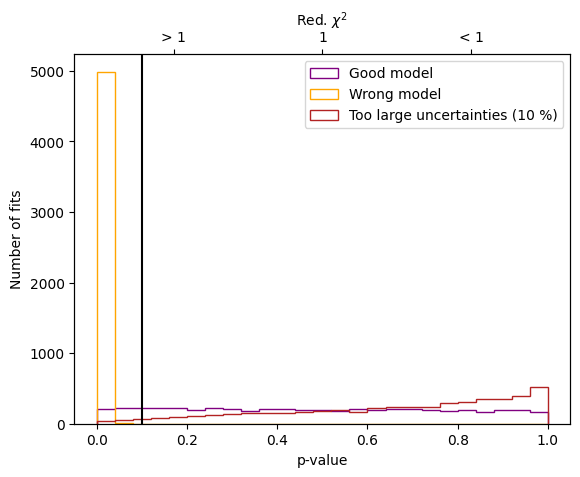

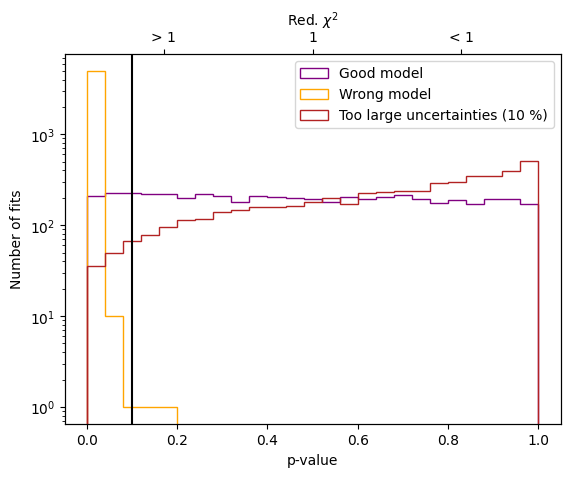

In [266]:
fig, axes = plt.subplots()
axes.hist(res_good_model, bins=25, range=(0, 1), histtype='step', color='purple', label='Good model')
axes.hist(res_wrong_model, bins=25, range=(0, 1), histtype='step', color='orange', label='Wrong model')
axes.hist(res_overfitting, bins=25, range=(0, 1), histtype='step', color='firebrick', label='Too large uncertainties (10 %)')
axes.set_xlabel('p-value')
axes.set_ylabel('Number of fits')
axes.legend()
axes.axvline(0.1, color='k')
axes2 = plt.twiny()
axes2.set_xlabel('Red. $\chi^2$')
axes2.set_xticks([0.2, 0.5, 0.8], ['> 1', '1', '< 1'])
plt.show()

axes.set_yscale('log')
fig

Wie man sieht, wird das falsche Modell nahezu immer verworfen während das richtige Modell meistens nicht verworfen wird. Das Modell mit dem überschätzten Fehler wird sogar häufiger akzeptiert, so dass man hier keine Unterscheidung vornehmen kann.

In [532]:
print(f'Fraction of wrong model fits rejected: {np.sum(res_wrong_model<0.1)/len(res_wrong_model):.4f}')
print(f'Fraction of good model fits rejected: {np.sum(res_good_model<0.1)/len(res_good_model):.4f}')
print(f'Fraction of overfitting model fits rejected: {np.sum(res_overfit_model<0.1)/len(res_overfit_model):.4f}')

Fraction of wrong model fits rejected: 0.9998
Fraction of good model fits rejected: 0.1002
Fraction of overfitting model fits rejected: 0.0250


Wenn man das Limit für den Hypothesen-Test auf 0,05 festlegt, ändern die Ergebnisse wie folgt:

In [533]:
print(f'Fraction of wrong model fits rejected: {np.sum(res_wrong_model<0.05)/len(res_wrong_model):.4f}')
print(f'Fraction of good model fits rejected: {np.sum(res_good_model<0.05)/len(res_good_model):.4f}')
print(f'Fraction of overfitting model fits rejected: {np.sum(res_overfit_model<0.05)/len(res_overfit_model):.4f}')

Fraction of wrong model fits rejected: 0.9986
Fraction of good model fits rejected: 0.0534
Fraction of overfitting model fits rejected: 0.0114


Der Hypothesen-Test kann das Modell nicht ablehnen, statt es zu bestätigen!